<hr style="height:5px;border-width:2;color:gray;background-color:#000000"> 
<center><h1>CS 234 - Fall 2022 - Linear-Time Construction of Suffix Trees</h1></center>
<center><h1>Due: Sunday, December 4th, 2022</h1></center>

### Enter your information below:

<div style="color: #000000;background-color: #EEEEFF">
    Your Name (submitter): Priyanshu Sharma  <br>
    Your student ID (submitter): 862395994
<br>
<br>
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>
<br>    
<br>
<B>Late work:</B> There is no late deadline for the final project, except for the most serious circumstances (illness, medical emergency, etc.) which have to be documented.
</div>


<hr style="height:5px;border-width:2;color:gray;background-color:#000000"> 
<center><h1>Ukkonen's algorithm</h1></center>
<br>
In this project you will implement the construction of suffix trees in linear-time using Ukkonen's algorithm. This algorithm was <B>not</B> explained in class. Part of this project is to understand how the algorithm works before starting the implementation. Here is some resources:
<UL>
    <li><A HREF="https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwijjZ-oso_3AhWiIUQIHetGA1IQFnoECAMQAQ&url=http%3A%2F%2Fresearch.engineering.nyu.edu%2F~greg%2Falgo2%2Fprojects%2FSuffix_Tree_Implementation.pdf&usg=AOvVaw0Dqiem0l4NxXi41DvXUQ3N">Gusfield's chapter on suffix trees</A> from his <A HREF="https://www.amazon.com/dp/0521585198">book</A></li>
    <li><A HREF="https://www.geeksforgeeks.org/ukkonens-suffix-tree-construction-part-1/">GeeksforGeeks</A></li>
    <li><A HREF="https://brenden.github.io/ukkonen-animation/">Ukkonen's animation</A>, step by step</li>
    <li><A HREF="https://stackoverflow.com/questions/9452701/ukkonens-suffix-tree-algorithm-in-plain-english">StackOverflow</A></li>
    <li>There are several videos on YouTube, e.g., <A HREF="https://www.youtube.com/watch?v=aPRqocoBsFQ">this one</A></li>
    <li>Use <A HREF="https://www.google.com/search?q=ukkonen+algorithm">Google</A> for more</li>
</UL>

Goals:
<UL>
    <LI>Write a working (bug-free) Python3 implementation of Ukkonen's algorithm in JupyterHub that runs in linear time</LI>
    <LI>Make sure that your implementation is correct: compare the output of your implementation to the output for the O(n^2) implementation that we used in Homework 2</LI>
    <LI>Collect experimental results on running your code for larger and larger inputs, say 1000, 2000, 5000, 10000, 100000 symbols, and plot the running time as a function of the input size</LI>
</UL>

You are allowed to study C/C++ implementations of Ukkonen's algorithm, but you have to write your own Python code. It is mandatory to acknowledge sources.


Instructions: - 

1. Here is the Project Website for Computational Methods for the Analysis of Biomolecular Data - https://priyanshu-sharma.github.io/cs234/. I have also added the complete Ukkonen Based Suffix Tree Construction code on the Project Wesite Repo - https://github.com/priyanshu-sharma/cs234/blob/master/ukkonen.py

2. For the First Time, you need to run the entire notebook sequentially to get the desired output. In order to test the code with different input you just need to run the "user_input_flow" method again and again with the input string. User will get a prompt to add the input string, enter the string and then press enter to proceed.

3. I have also added a video explaining my complete code. Kindly refer to that in case of any issue. I have tested my entire code for multiple use-cases (different strings).

4. I have also included the Defination (Responsibility, Input, and Output) for each Function and Class in order to give the overview of the code.

In [166]:
# INSTALLING DEPENDENCY LIBRARY "labml" in order to get better insights from logs.

In [167]:
!pip install labml
from labml import logger
from labml.logger import Text, Color

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [168]:
# IMPORTS

In [169]:
import time
import logging

logging.basicConfig(level=logging.DEBUG)
from operator import attrgetter as at
import matplotlib.pyplot as plt
import pandas as pd

In [170]:
leaf_end_value = -1

In [171]:
# MAIN CLASS DEFINATION (UkkonenSuffixTree and UkkonenSuffixNode) AND ITS MEMBER FUNCTIONs AND VARIABLES

In [172]:
class UkkonenSuffixTree:
    def __init__(self, formatted_string):
        """
        Responsiblity: Main Method to build Ukkonen
            Based Suffix Tree.
        Input: formatted_string = input_string + "$".
        Ouput: Newly Contructed Suffix Tree Based on
            Ukkonen Algorithm.
        """
        self.formatted_string = formatted_string
        self.size = -1
        self.root_node = None
        self.latest_node = None
        self.act_node = None
        self.act_edge = -1
        self.act_len = 0
        self.remainder = 0
        self.root_end = None
        self.split_end = None

    def calculate_next_node_and_effective_length(self):
        """
        Responsiblity: Node Hopping, mainly calculate
            next node and remaining length in the
            string which is also known as effective
            length.
        """
        return self.act_node.children_node.get(self.formatted_string[self.act_edge]), (
            self.act_node.children_node.get(
                self.formatted_string[self.act_edge]
            ).ending_value
            - self.act_node.children_node.get(
                self.formatted_string[self.act_edge]
            ).starting_value
            + 1
        )

    def check_for_rule_two_extension(self, split_node=None):
        """
        Responsiblity: If not a first node to be
            created after the split in one phase
            create a suffix link between previously
            inserted and new inserted node.
        """
        if self.latest_node is not None:
            if split_node is None:
                self.latest_node.s_link = self.act_node
                self.latest_node = None
            else:
                self.latest_node.s_link = split_node
                self.latest_node = split_node

    def check_for_rule_three_extension(self, index):
        """
        Responsiblity: If split occur when active
            node is not on a root node then follow
            the suffix link to get the new active
            node.
        """
        if (self.act_node == self.root_node) and (self.act_len > 0):
            self.act_len -= 1
            self.act_edge = index - self.remainder + 1
        elif self.act_node != self.root_node:
            self.act_node = self.act_node.s_link

    def initializing_the_value_and_add_root_node(self):
        """
        Responsibility: Calculate total size of
            formatted_string and initializing the
            new root node to start the process
            and setting active node to new
            inserted root node.
        """
        self.size = len(self.formatted_string)
        self.root_end = -1
        new_root_node = UkkonenSuffixNode(False)
        new_root_node.s_link = self.root_node
        new_root_node.starting_value = -1
        new_root_node.ending_value = self.root_end
        new_root_node.s_index = -1
        self.root_node = new_root_node
        self.act_node = self.root_node

    def iterate_char_by_char(self):
        """
        Responsibility: Iterate char by char
            and update remainder and latest
            node and pass the index for
            further processing.
        """
        for index in range(self.size):
            global leaf_end_value
            leaf_end_value = index
            self.remainder += 1
            self.latest_node = None
            self.insert_char_in_suffix_tree(index)

    def traverse_tree(self):
        """
        Responsiblity: To output the newly
            constructed suffix tree based on
            the values given by tree_traversal()
            function.
        Input: UkkonenSuffixTree Class Function.
        Ouput: Print the children of the tree in
            Depth First Search Way. One can also
            replicate the same for Breadth First
            Search way.
        """
        for child in self.tree_traversal(self.root_node):
            print(child)

    def set_act_edge_to_current_index(self, index):
        """
        Responsibility: Updating active edge to
            current index for every new phase.
        """
        if self.act_len == 0:
            self.act_edge = index

    def construct_suffix_tree(self):
        """
        Responsiblity: Main Method to build Ukkonen
            Based Suffix Tree.
        Input: formatted_string = input_string + "$".
        Ouput: Newly Contructed Suffix Tree Based on
            Ukkonen Algorithm.
        """
        self.initializing_the_value_and_add_root_node()
        self.iterate_char_by_char()

    def tree_traversal(self, current_node):
        """
        Responsiblity: Starting from root_node
            it will first fetch all the child_no
            de of root_node and then for each
            child_node of root_node it will again
            fetch their all the child_nodes.
        Input: UkkonenSuffixTree Class Funcation
            + Accept the Current Node. Initially
            it will be root node.
        Ouput: Print the child_node of each node
            in Depth-First Search Way.
        """
        starting_value, ending_value = (
            current_node.starting_value,
            current_node.ending_value,
        )
        yield self.formatted_string[starting_value : ending_value + 1]

        for child_node in current_node.children_node.values():
            if child_node:
                yield from self.tree_traversal(child_node)

    def create_split_node(self, next_node, index):
        """
        Responsibility: Create new split_node after
            every split in every phase and also
            initiate child node for the same split
            node and update the starting_values.
        Input: Next Node Pointer and Index.
        Output: Newly Constructed Split Node.
        """
        new_split_node = UkkonenSuffixNode(False)
        new_split_node.s_link = self.root_node
        new_split_node.starting_value = next_node.starting_value
        new_split_node.ending_value = self.split_end
        new_split_node.s_index = -1
        split_node = new_split_node
        self.act_node.children_node[self.formatted_string[self.act_edge]] = split_node
        split_child_node = UkkonenSuffixNode(True)
        split_child_node.s_link = self.root_node
        split_child_node.starting_value = index
        split_child_node.ending_value = None
        split_child_node.s_index = -1
        split_node.children_node[self.formatted_string[index]] = split_child_node
        next_node.starting_value += self.act_len
        split_node.children_node[
            self.formatted_string[next_node.starting_value]
        ] = next_node
        return split_node

    def insert_char_in_suffix_tree(self, index):
        """
        Responsibility: For Every Phase, orchestrator
            the rule one, rule two and rule three
            logic along with node hopping and Split
            Node Logic.
        """
        while self.remainder > 0:
            self.set_act_edge_to_current_index(index)
            if (
                self.act_node.children_node.get(self.formatted_string[self.act_edge])
                is None
            ):
                new_node = UkkonenSuffixNode(True)
                new_node.s_link = self.root_node
                new_node.starting_value = index
                new_node.ending_value = None
                new_node.s_index = -1
                self.act_node.children_node[
                    self.formatted_string[self.act_edge]
                ] = new_node
                self.check_for_rule_two_extension()
            else:
                (
                    next_node,
                    effective_length,
                ) = self.calculate_next_node_and_effective_length()
                if self.act_len >= effective_length:
                    self.act_edge += effective_length
                    self.act_len -= effective_length
                    self.act_node = next_node
                    continue
                if (
                    self.formatted_string[next_node.starting_value + self.act_len]
                    == self.formatted_string[index]
                ):
                    self.check_for_rule_two_extension()
                    self.act_len += 1
                    break
                self.split_end = next_node.starting_value + self.act_len - 1
                split_node = self.create_split_node(next_node, index)
                self.check_for_rule_two_extension(split_node)
            self.remainder -= 1
            self.check_for_rule_three_extension(index)


class UkkonenSuffixNode:
    """
    Responsibility: Initialize every node
        of UkkonenSuffixTree and also
        initiate other important member
        variable for the same node class.
    """

    def __init__(self, leaf_node):
        self.children_node = {}
        self.leaf_node = leaf_node
        self.s_index = None
        self.starting_value = None
        self.ending_value = None
        self.s_link = None

    def __eq__(self, ukkonen_suffix_node):
        atg = at("starting_value", "ending_value", "s_index")
        if atg(self) == atg(ukkonen_suffix_node):
            return True
        return False

    def __ne__(self, ukkonen_suffix_node):
        atg = at("starting_value", "ending_value", "s_index")
        if atg(self) != atg(ukkonen_suffix_node):
            return True
        return False

    def __getattribute__(self, attribute_name):
        if attribute_name == "ending_value":
            if self.leaf_node:
                return leaf_end_value
        return super(UkkonenSuffixNode, self).__getattribute__(attribute_name)

In [173]:
def construct_suffix_tree_using_ukkonen(formatted_string):
    """
    Responsiblity: Main Method to build Ukkonen
        Based Suffix Tree.
    Input: formatted_string = input_string + "$".
    Ouput: Newly Contructed Suffix Tree Based on
        Ukkonen Algorithm.
    """
    ukkonen_suffix_tree = UkkonenSuffixTree(formatted_string)
    ukkonen_suffix_tree.construct_suffix_tree()
    return ukkonen_suffix_tree

In [174]:
def user_input_flow():
    """
    Responsiblity: Mainly involved in taking
        user input and then formatting the
        same. Then we will invoke the main
        funcation in order to construct the
        Tree based on Ukkonen Algorithm.
        Post that Traversing the Newly
        Constructed Suffix Tree.
    Input: User Entered Input String.
    Output: Constructed Tree Based on
        Ukkonen Algorithm.
    """
    input_string = input("Enter the input string : ")
    formatted_string = input_string + "$"
    logger.log("Your fomatted string will be : {}\n".format(formatted_string), Text.highlight)
    logger.log("----------Started Constructing Suffix Tree-------------", Text.highlight)
    start_time = time.time()
    ukkonen_suffix_tree = construct_suffix_tree_using_ukkonen(formatted_string)
    end_time = time.time()
    logger.log("----------Suffix Tree Construction Completed-------------", Text.highlight)
    logger.log(
        "Construction of Suffix Tree using Ukkonen Algorithm took around : {} seconds".format(
            end_time - start_time
        ), Text.meta2
    )
    logger.log("----------Traversing the Newly Constructed Suffix Tree-------------", Text.highlight)
    ukkonen_suffix_tree.traverse_tree()

In [175]:
# Example 1 - abcabxabcd

In [176]:
user_input_flow()

Enter the input string : abcabxabcd



ab
xabcd$
c
d$
abxabcd$
b
xabcd$
cabxabcd$
c
d$
abxabcd$
xabcd$
d$


In [177]:
# Example 2 - mississippi

In [178]:
user_input_flow()

Enter the input string : mississippi



mississippi$
i
ppi$
ssi
ppi$
ssippi$
$
s
i
ppi$
ssippi$
si
ppi$
ssippi$
p
i$
pi$
$


In [179]:
# Example 3 - gattaca

In [180]:
user_input_flow()

Enter the input string : gattaca



gattaca$
a
ca$
ttaca$
$
t
aca$
taca$
ca$
$


In [181]:
# Example 4 - abaababaabaababaababa

In [182]:
user_input_flow()

Enter the input string : abaababaabaababaababa



a
ababaabaababaababa$
ba
ba
$
abaababaababa$
aba
ababaababa$
baaba
ba$
ababaababa$
ba
baabaababaababa$
ababa
$
abaababaababa$
$
$


In [183]:
# Goal 1 - Completed with the above implementation
# Goal 2 - I have compared the Example 1, 2, 3, and 4 with the O(n^2) implementation of the suffix trees. Results are consistent with my version of ukkonen algorithm.
#          I have also compared the above example results with the results and visualizations obtained from this Brenden Ukkonen Animation Website (Mentioned in the Project Defination 
#          in the starting as "Ukkonen's animation, step by step"). - https://brenden.github.io/ukkonen-animation/
# Goal 3 - Here is the comparsion for running the code for larger and larger inputs, say 1000, 2000, 5000, 10000, 100000 symbols, and here is plot the running time as a function of the input size.

In [184]:
"""
Constructing inputs of different size say 1000, 2000, 5000, 10000, 100000 and storing them in input_strings list.
"""
a = ""
test_string = "ababaabaababaababaab"
sizes = [1000, 2000, 5000, 10000, 100000]
input_strings = []
for i in sizes:
  while(len(a) < i):
    a = a + test_string
  input_strings.append(a)
  print("length - {}, string - {}".format(len(a), a))

length - 1000, string - ababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaaba

In [185]:
print(input_strings)
print(len(input_strings))

['ababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababaabababaabaababaababa

In [186]:
"""
This is modified version of the user_input_flow, this will not take input from user
instead of this it will iterate on all the strings of different length obtained from
previous process.

Note - We have also commented out this line: -  #ukkonen_suffix_tree.traverse_tree()
as we are getting the maximum recursion depth error due to DFS Traversal of the Constructed
Trees.
"""
construction_time_array = []
def modified_user_input_flow(input_strings):
    """
    Responsiblity: Mainly involved in taking
        user input and then formatting the
        same. Then we will invoke the main
        funcation in order to construct the
        Tree based on Ukkonen Algorithm.
        Post that Traversing the Newly
        Constructed Suffix Tree.
    Input: User Entered Input String.
    Output: Constructed Tree Based on
        Ukkonen Algorithm.
    """    
    for input_string in input_strings:
      # input_string = input("Enter the input string : ")
      formatted_string = input_string + "$"
      logger.log("Your fomatted string will be : {}\n".format(formatted_string), Text.highlight)
      logger.log("----------Started Constructing Suffix Tree-------------", Text.highlight)
      start_time = time.time()
      ukkonen_suffix_tree = construct_suffix_tree_using_ukkonen(formatted_string)
      end_time = time.time()
      logger.log("----------Suffix Tree Construction Completed-------------", Text.highlight)
      logger.log(
          "Construction of Suffix Tree using Ukkonen Algorithm took around : {} seconds".format(
              end_time - start_time
          ), Text.meta2
      )
      construction_time_array.append(end_time - start_time)
      logger.log("----------construction_time_array-------------{}".format(construction_time_array), Text.highlight)
      logger.log("----------Traversing the Newly Constructed Suffix Tree-------------", Text.highlight)
      #ukkonen_suffix_tree.traverse_tree()
    print(construction_time_array)

In [187]:
modified_user_input_flow(input_strings)

[0.01941990852355957, 0.030874252319335938, 0.048352718353271484, 0.11027312278747559, 1.1023533344268799]


In [188]:
input_size = [1000, 2000, 5000, 10000, 100000]
"""
Constructed Time Array is obtained from the result of the previous function.
"""
print(construction_time_array)

[0.01941990852355957, 0.030874252319335938, 0.048352718353271484, 0.11027312278747559, 1.1023533344268799]


   Input Size  Construction Time
0        1000           0.019420
1        2000           0.030874
2        5000           0.048353
3       10000           0.110273
4      100000           1.102353


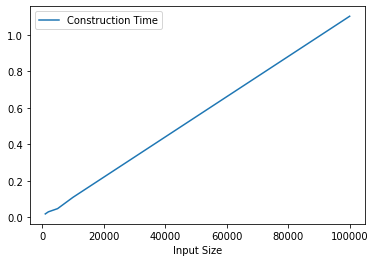

In [189]:
"""
Plotting the graph between input size and construction time
"""
dictionary = dict(zip(input_size, construction_time_array))
df = pd.DataFrame(dictionary.items(), columns=['Input Size', 'Construction Time'])
print(df.head(5))

df.plot(x='Input Size', y='Construction Time', kind='line')
plt.show()

In [190]:
## Construction Time increases linearly as the input size increases. As a Conclusion this construction algorithm using Ukkonen Method has Time Complexity of O(n). 
## Most Challenging Part was the implementation of the suffix links and split node logic. As we need to handle the new node creation using both suffix link and split node logic.